```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

In this notebook we will load the true state, and simply take a look on the data we got.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Investigating the truth

In this notebook we will load the true state, and simply take a look on the data we got.

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
#Create output directory for images
#imgdir = 'double_jet'
#filename_prefix = imgdir + "/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + "_"
#os.makedirs(imgdir, exist_ok=True)
#print("Saving images to " + imgdir)

# The data

The data used for this paper is available for download from [the GPU Ocean server](http://gpu-ocean.met.no:9000/gpu_ocean/DAPaper/).

Please start with downloading the files `double_jet_ensemble_init.zip` and `double_jet_truth.zip` to this folder, and unzip them so that the following lines of code passes:

In [4]:
ensemble_init_path = os.path.abspath('double_jet_ensemble_init/')
assert len(os.listdir(ensemble_init_path)) == 102, "Ensemble init folder has wrong number of files"

truth_path = os.path.abspath('double_jet_truth/')
assert len(os.listdir(truth_path)) == 4, "Truth folder has wrong number of files"

### Define functions for plotting

In [5]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,3), interior=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    range_eta = np.max(np.abs(eta))
    range_huv = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=-range_eta, vmax=range_eta)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=-range_huv, vmax=range_huv)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, drifter_set=[]):
    drifter_positions = observations.get_drifter_position(t)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
    ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:pale cyan'
        if i in drifter_set:
            color = 'xkcd:tomato red'
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)

    
def days_to_sec(days):
    return days*24*60*60

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

# Read truth and investigate

Reading files...

In [6]:
truth_state_filename = os.path.join(truth_path, "double_jet_case_truth.nc")
observations_filename = os.path.join(truth_path, "drifter_observations.pickle")

truth_reader = SimReader.SimNetCDFReader(truth_state_filename)
observations = Observation.Observation()
observations.read_pickle(observations_filename)

# Plot state and drifters 
Look at 
- spin up state (day 3) 
- mid-DA state (day 6.5)
- Now-state (day 10)
- Forecast state (day 13)


In [7]:
drifter_set = np.arange(0, 64, 7)
drifter_set = np.array([3, 8, 13, 23, 26, 38, 43, 49, 55, 61])+2
print(len(drifter_set))
print(drifter_set)

10
[ 5 10 15 25 28 40 45 51 57 63]


259200.0 259200


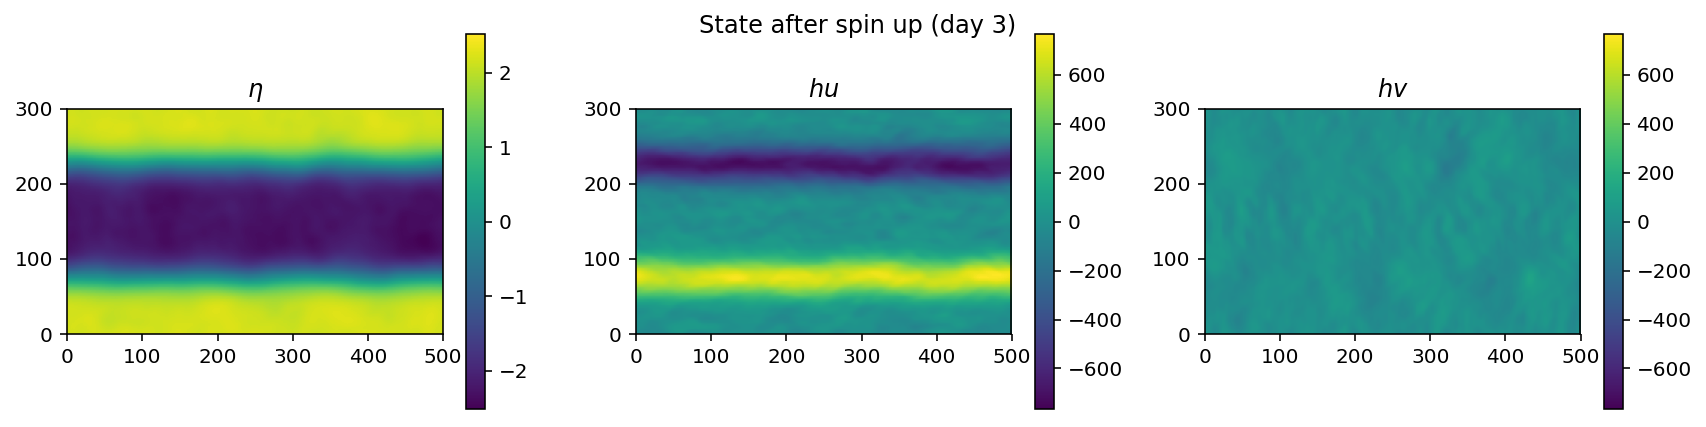

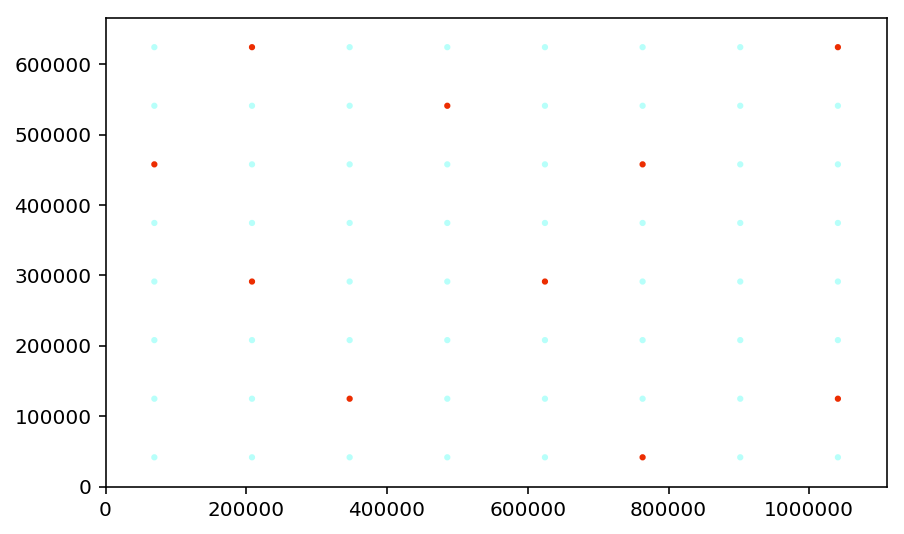

In [8]:
t_spinup = days_to_sec(3)
t_spinup_index = truth_time_step(t_spinup)
eta, hu, hv, t = truth_reader.getTimeStep(t_spinup_index)

print(t, t_spinup)
imshow3(eta, hu, hv, title='State after spin up (day 3)')

plotDrifters(observations, truth_reader, t_spinup, drifter_set)

561600.0 561600.0


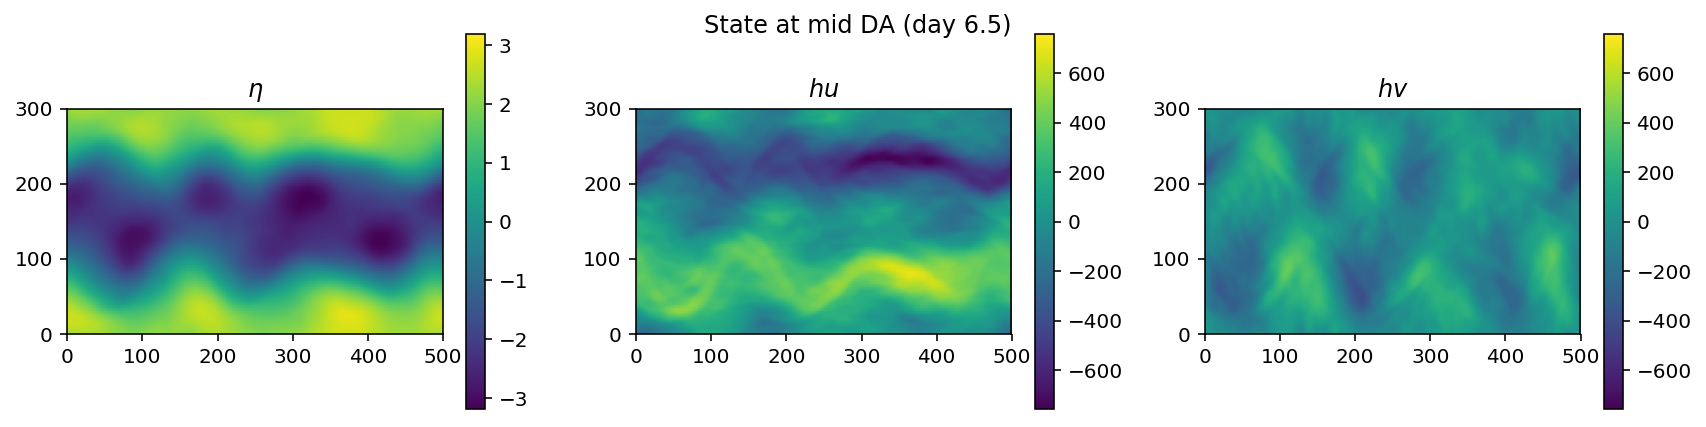

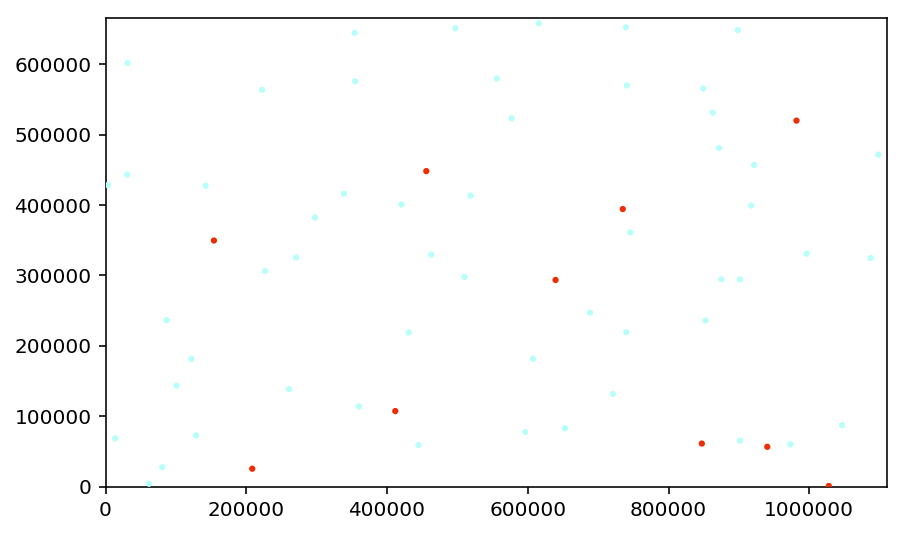

In [9]:
t_midDA = days_to_sec(6.5)
t_midDA_index = truth_time_step(t_midDA)
eta, hu, hv, t = truth_reader.getTimeStep(t_midDA_index)

print(t, t_midDA)
imshow3(eta, hu, hv, title='State at mid DA (day 6.5)')

plotDrifters(observations, truth_reader, t_midDA, drifter_set)

864000.0 864000


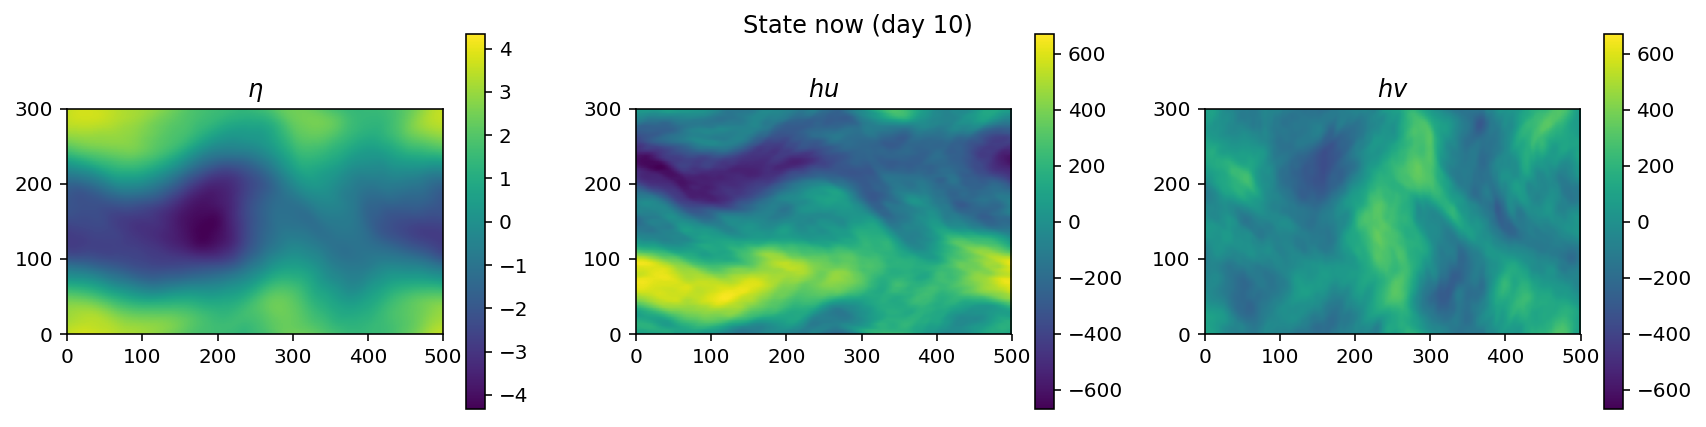

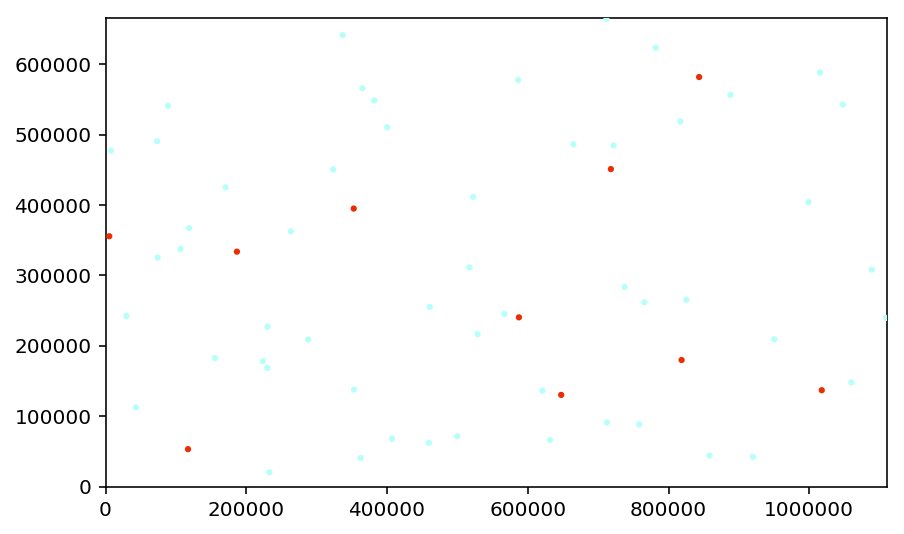

In [10]:
t_now = days_to_sec(10)
t_now_index = truth_time_step(t_now)
eta, hu, hv, t = truth_reader.getTimeStep(t_now_index)

print(t, t_now)
imshow3(eta, hu, hv, title='State now (day 10)')

plotDrifters(observations, truth_reader, t_now, drifter_set)

1123200.0 1123200


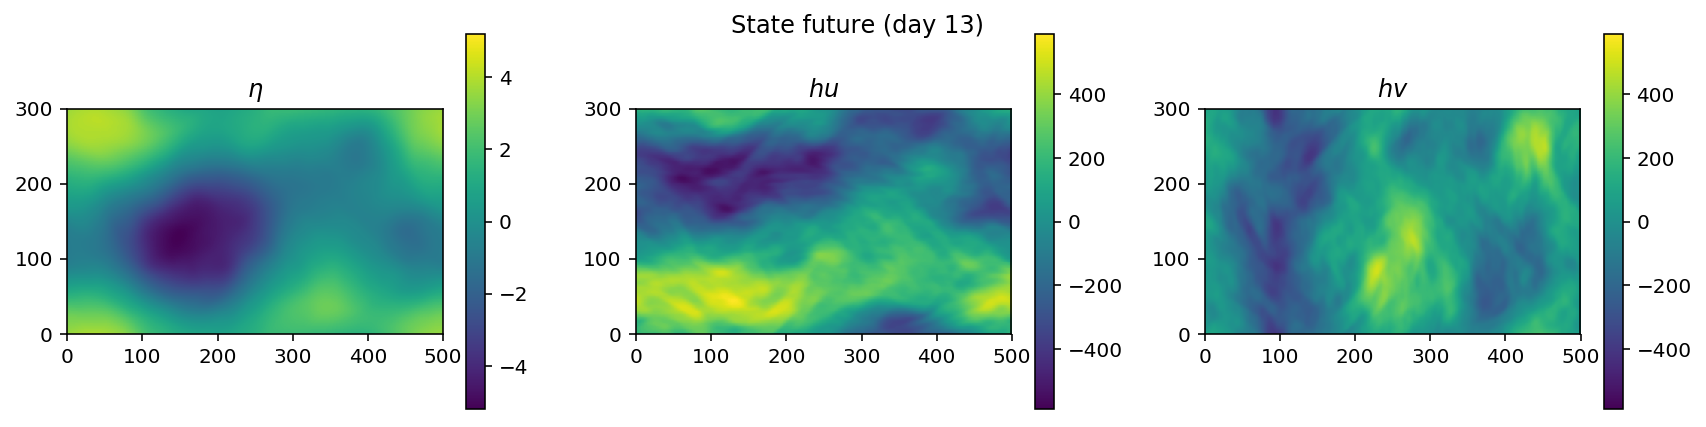

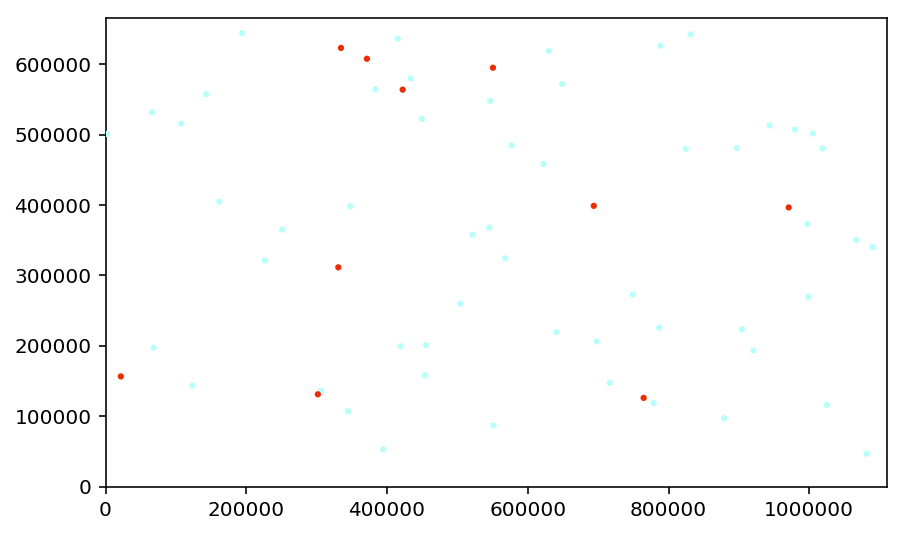

In [11]:
t_future = days_to_sec(13)
t_future_index = truth_time_step(t_future)
eta, hu, hv, t_last = truth_reader.getLastTimeStep()

print(t_last, t_future)
imshow3(eta, hu, hv, title='State future (day 13)')

plotDrifters(observations, truth_reader, t_future, drifter_set)

drifter set: [ 5 10 15 25 28 40 45 51 57 63]
getting path for drifter 5
getting path for drifter 10
getting path for drifter 15
getting path for drifter 25
getting path for drifter 28
getting path for drifter 40
getting path for drifter 45
getting path for drifter 51
getting path for drifter 57
getting path for drifter 63


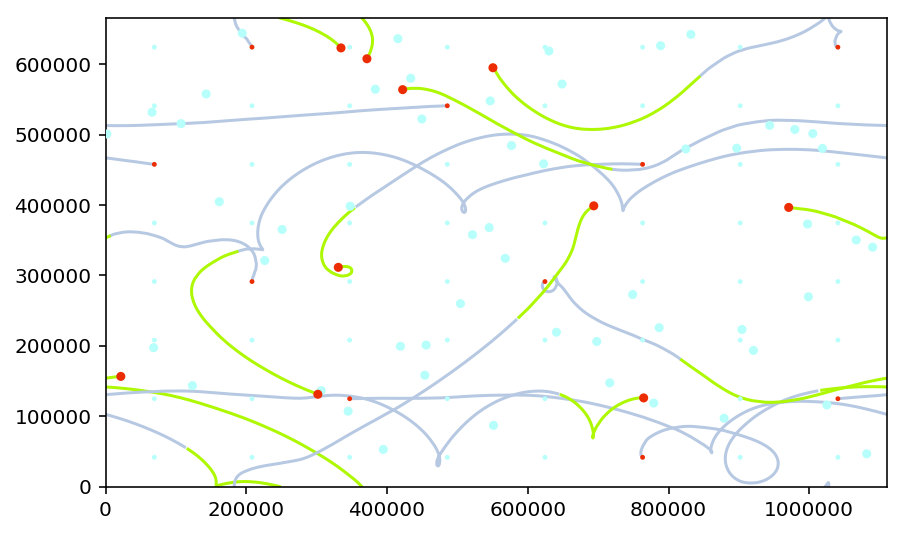

In [14]:
times_da = np.arange(days_to_sec(3), days_to_sec(10), 60*60)
times_f  = np.arange(days_to_sec(10), days_to_sec(13), 60*60)

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
nx, ny = truth_reader.get('nx'), truth_reader.get('ny')
dx, dy = truth_reader.get('dx'), truth_reader.get('dy')

emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

print('drifter set:', drifter_set)
for drifter_id in drifter_set:
    print('getting path for drifter ' + str(drifter_id))
    paths_da = observations.get_drifter_path(drifter_id, times_da[0], times_da[-1])
    for path in paths_da:
        ax.plot(path[:,0], path[:,1], color='xkcd:light blue grey')
    
    paths_f = observations.get_drifter_path(drifter_id, times_f[0], times_f[-1])
    for path in paths_f:
        ax.plot(path[:,0], path[:,1], color='xkcd:lemon green')

drifter_positions_start = observations.get_drifter_position(t_spinup)
for i in range(drifter_positions_start.shape[0]):
    color = 'xkcd:pale cyan'
    if i in drifter_set:
        color = 'xkcd:tomato red'
    circ_end = matplotlib.patches.Circle((drifter_positions_start[i,0], drifter_positions_start[i,1]),
                                         2000, fill=True, zorder=10, color=color)
    ax.add_patch(circ_end)
    
drifter_positions_end = observations.get_drifter_position(t_future)
for i in range(drifter_positions_end.shape[0]):
    color = 'xkcd:pale cyan'
    if i in drifter_set:
        color = 'xkcd:tomato red'
    circ_end = matplotlib.patches.Circle((drifter_positions_end[i,0], drifter_positions_end[i,1]),
                                         5000, fill=True, zorder=10, color=color)
    ax.add_patch(circ_end)